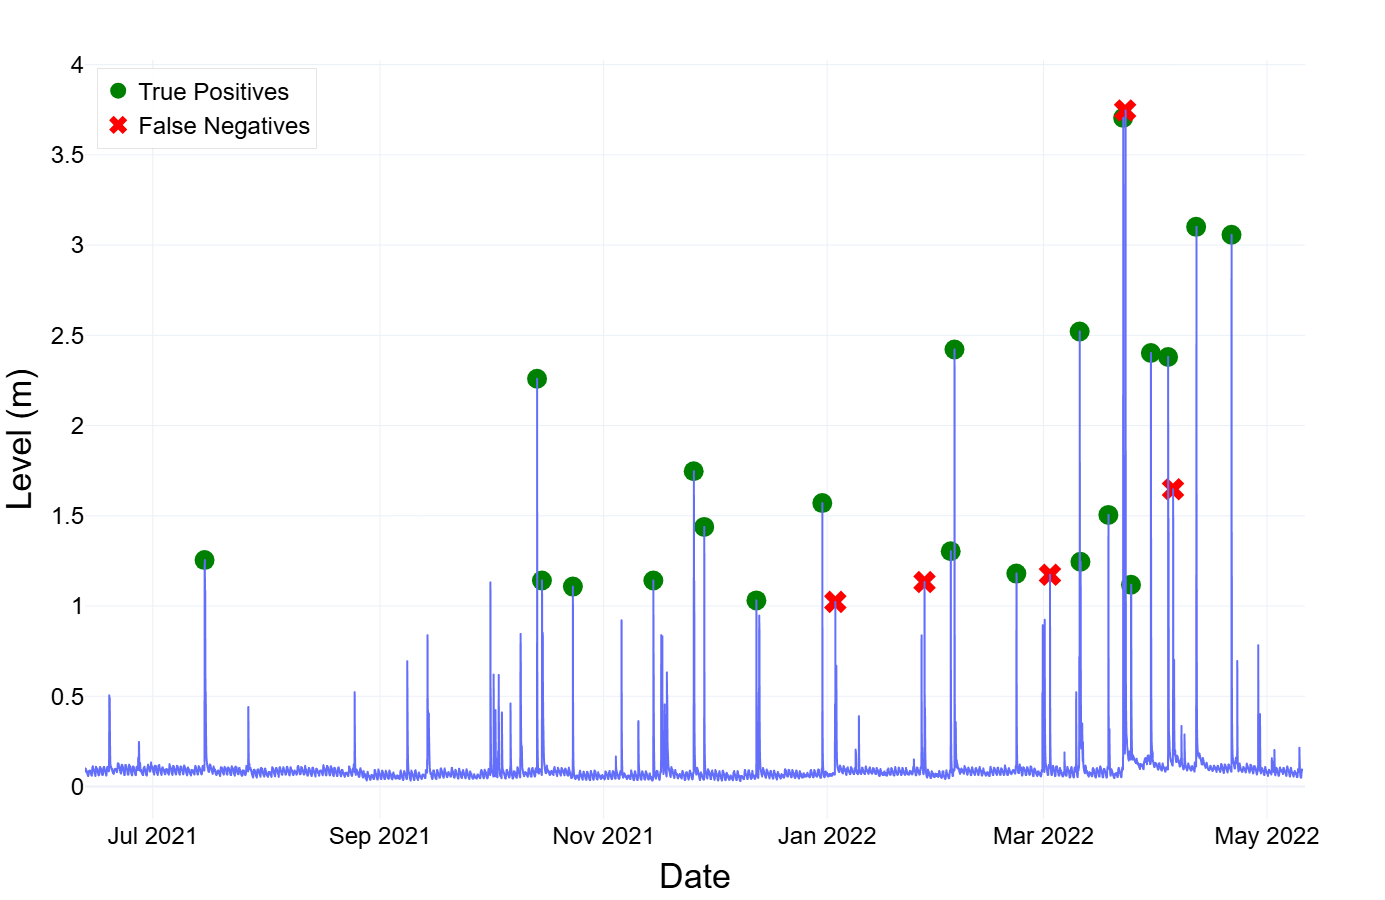

In [33]:
import pandas as pd
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import plotly.express as px
import plotly.graph_objects as go

# --- carga y preparación de datos ---
data = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/data/data_for_clustering_1.csv')
features_f1 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/SVM_best_features_f1_1.csv')

df = data.copy().drop(columns=["fecha"])
y = df["event"].astype(int).values

best_features_f1 = features_f1['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()
lista_features_f1 = best_features_f1[1]

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# --- evaluación del modelo ---
def evaluate_model(feature_list):
    X = df[feature_list]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
    
    cm = confusion_matrix(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return y_pred, cm, prec, rec, f1

pred, cm, prec_val, rec_val, f1_val = evaluate_model(lista_features_f1)

# --- matriz de confusión ---
cm_df = pd.DataFrame(cm,
                     index=["False event", "True event"],
                     columns=["Pred false", "Pred true"])
title_cm = (f"Confusion Matrix\n"
            f"Precision: {prec_val:.4f}, Recall: {rec_val:.4f}, F1: {f1_val:.4f}")

fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale="Blues")
fig_cm.update_layout(
    title=title_cm,
    xaxis_title="Predicted",
    yaxis_title="Real"
)
#fig_cm.show()

# --- gráfico de nivel con marcadores TP y FN ---
# --- carga y formateo de la serie de nivel ---
df_nivel = pd.read_csv(
    '/home/nivelrios/documentos/Mburicao Project/data/processed/nivel_processed.csv'
)
df_nivel['fecha'] = pd.to_datetime(df_nivel['fecha'])

# --- filtrar al rango deseado ---
start = pd.to_datetime('2021-06-12 12:00:00')
end   = pd.to_datetime('2022-05-10 15:10:00')
df_nivel = df_nivel[(df_nivel['fecha'] >= start) & (df_nivel['fecha'] <= end)]

# --- gráfico de nivel dentro del rango ---
fig_level = px.line(
    df_nivel,
    x="fecha",
    y="nivel",
    labels={'fecha': 'Date', 'nivel': 'Level (m)'},
    template='plotly_white'
)

fig_level.update_traces(
    selector=dict(type='scatter', mode='lines'),
    line=dict(color='blue', width=2)
)

# Añade True Positives y False Negatives
fig_level.add_trace(go.Scatter(
    x=tp['fecha'],
    y=tp['global_peak'],
    mode='markers',
    name='True Positives',
    marker=dict(color='green', size=20, symbol='circle')
))
fig_level.add_trace(go.Scatter(
    x=fn['fecha'],
    y=fn['global_peak'],
    mode='markers',
    name='False Negatives',
    marker=dict(color='red', size=20, symbol='x')
))

# Ajustes de layout con leyenda ampliada y borde más grueso
fig_level.update_layout(
    title_font=dict(size=34, color='black', family='Arial'),
    xaxis=dict(
        title='Date',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    yaxis=dict(
        title='Level (m)',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    autosize=False,
    width=900,
    height=900,
    legend=dict(
        x=0.01,
        y=0.99,
        bordercolor='rgba(0, 0, 0, 0.1)',    # Borde semi-transparente,
        borderwidth=1,            # borde más grueso
        bgcolor='rgba(255,255,255,0.9)',  # fondo blanco semitransparente
        font=dict(
            family='Arial',
            size=24,              # tamaño de fuente mayor
            color='black'
        ),
    )
)

fig_level.show()


In [11]:
fecha inicio: 2021-06-12 12:00:00'
fecha fin: '2022-05-10 15:10:00'
